In [33]:
import matplotlib.pyplot as plt
import numpy as np
import yaml

In [34]:
data = None
with open("benchmark_results.yaml") as stream:
    try:
        data = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

In [35]:
from uncertainties import unumpy
implementations = [key for key in data["200.yaml"]]
grid_sizes = [int(key.split(".")[0]) for key in data]
grid_sizes.sort()

FLOP_per_cell = 85
num_iterations=5000
total_FLOP = np.array([size*size*FLOP_per_cell*num_iterations for size in grid_sizes])

def to_key(size):
    return "{}.yaml".format(size)

implementations_dict = {}

for implementation in implementations:
    median = []
    mean = []
    max = []
    min = []
    std = []
    
    for size in grid_sizes:
        if(implementation in data[to_key(size)]):
            times = data[to_key(size)][implementation]["time"]
            
            median.append(times["median"])
            mean.append(times["mean"])
            min.append(times["min"])
            max.append(times["max"])
            std.append(times["std"])
            
            
    implementations_dict[implementation] = {
        "median" : np.array(median),
        "mean" : np.array(mean),
        "max" : np.array(max),
        "min" : np.array(min),
        "std" : np.array(std)
    }
    
baseline = "cpp_naive"
baselines_times = unumpy.uarray(implementations_dict[baseline]["mean"], implementations_dict[baseline]["std"])

for implementation in implementations_dict:
    print(implementation)
    min_length = np.min([implementations_dict[implementation]["mean"].size, implementations_dict[baseline]["mean"].size])
    implementation_times = unumpy.uarray(implementations_dict[implementation]["mean"][:min_length], implementations_dict[implementation]["std"][:min_length])
    speedup = baselines_times[:min_length] / implementation_times
    FLOPs = total_FLOP[:min_length] / implementation_times
    implementations_dict[implementation]["speedup"] = {}
    implementations_dict[implementation]["speedup"]["mean"] = unumpy.nominal_values(speedup)
    implementations_dict[implementation]["speedup"]["std"] = unumpy.std_devs(speedup)
    implementations_dict[implementation]["FLOPs"] = {}
    implementations_dict[implementation]["FLOPs"]["mean"] = unumpy.nominal_values(FLOPs)
    implementations_dict[implementation]["FLOPs"]["std"] = unumpy.std_devs(FLOPs)
    

pytorch_conv
julia_parallel_stencil_8_threads
julia_cuda_stencil
julia_parallel_stencil
numpy_array
cpp_cuda_stencil
python_lists
julia_cuda_array
pytorch_array
julia_sequential_array
julia_parallel_stencil_24_threads
cpp_naive
julia_sequential_stencil
julia_parallel_stencil_12_threads


/home/daniel/anaconda3/envs/i2dl/lib/python3.10/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in <lambda> (vectorized)
  outputs = ufunc(*inputs)


In [36]:
implementations_dict["julia_parallel_stencil"]["label"] = "Julia parallel stencil 4 threads"
implementations_dict["julia_parallel_stencil_8_threads"]["label"] = "Julia parallel stencil 8 threads"
implementations_dict["julia_parallel_stencil_12_threads"]["label"] = "Julia parallel stencil 12 threads"
implementations_dict["julia_parallel_stencil_24_threads"]["label"] = "Julia parallel stencil 24 threads"
implementations_dict["pytorch_array"]["label"] = "Pytorch array programming"
implementations_dict["julia_sequential_array"]["label"] = "Julia sequential array programming"
implementations_dict["numpy_array"]["label"] = "Numpy sequential array programming"
implementations_dict["cpp_cuda_stencil"]["label"] = "CUDA-C stencil"
implementations_dict["python_lists"]["label"] = "Python sequential lists"
implementations_dict["pytorch_conv"]["label"] = "Pytorch Conv2d layer with stencil weights"
implementations_dict["julia_sequential_stencil"]["label"] = "Julia sequential stencil"
implementations_dict["julia_cuda_stencil"]["label"] = "CUDA.jl stencil"
implementations_dict["julia_cuda_array"]["label"] = "CUDA.jl array programming"
implementations_dict["cpp_naive"]["label"] = "Naive sequential C++ implementation"

implementations_dict["julia_parallel_stencil"]["color"] = "thistle"
implementations_dict["julia_parallel_stencil"]["marker"] = "."
implementations_dict["julia_parallel_stencil_8_threads"]["color"] = "plum"
implementations_dict["julia_parallel_stencil_12_threads"]["color"] = "violet"
implementations_dict["julia_parallel_stencil_24_threads"]["color"] = "purple"

implementations_dict["pytorch_array"]["color"] = "lightcoral"
implementations_dict["pytorch_conv"]["color"] = "firebrick"

implementations_dict["julia_sequential_array"]["color"] = "blue"
implementations_dict["julia_sequential_stencil"]["color"] = "darkturquoise"

implementations_dict["cpp_naive"]["color"] = "black"

implementations_dict["numpy_array"]["color"] = "gold"
implementations_dict["python_lists"]["color"] = "cornflowerblue"

implementations_dict["cpp_cuda_stencil"]["color"] = "chartreuse"
implementations_dict["julia_cuda_array"]["color"] = "darkgreen"
implementations_dict["julia_cuda_stencil"]["color"] = "limegreen"

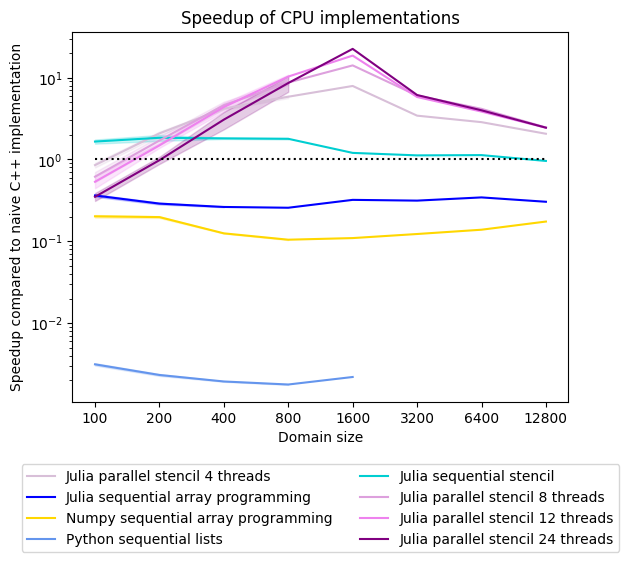

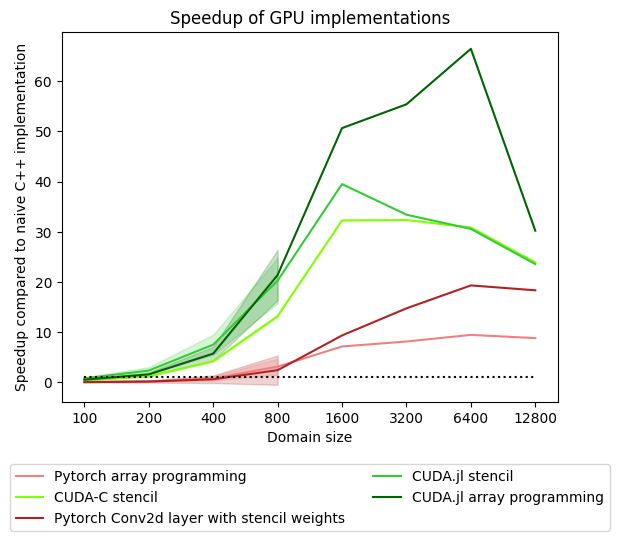

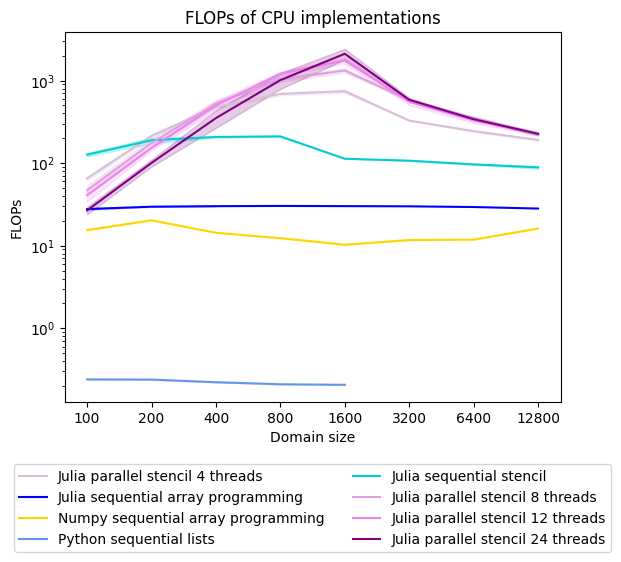

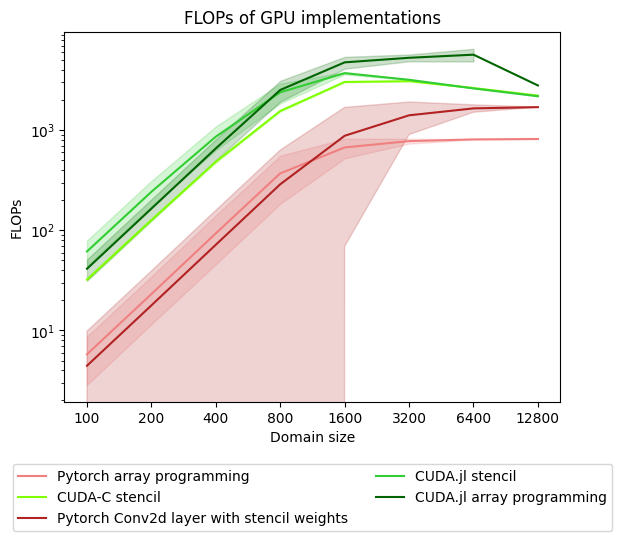

In [43]:

def plot_implementations(implementations, data_dict, category="speedup"):
    max_x = 0
    max_y = 0
    min_y = 1e20
    
    for implementation in implementations:
        data = data_dict[implementation][category]
        multiplier = 1
        if category == "FLOPs":
            multiplier = 1 / 1e+9
        space = np.linspace(1, data["mean"].size, data["mean"].size)
        plt.plot(space, data["mean"] * multiplier, label=implementations_dict[implementation]["label"], color=implementations_dict[implementation]["color"])
        plt.fill_between(space, (data["mean"] - data["std"]) * multiplier, (data["mean"] + data["std"]) * multiplier, alpha=0.2, color=implementations_dict[implementation]["color"])
        max_x = np.max([max_x, space.size])
        max_y = np.max([max_y, np.max(data["mean"])])
        min_y = np.min([min_y, np.min(data["mean"])])
        
    plt.xticks(np.linspace(1, 8, 8), grid_sizes)
    plt.xlabel("Domain size")
    plt.ylabel("Speedup compared to naive C++ implementation")
    plt.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=2)
    if category == "FLOPs":
        plt.ylabel("FLOPs")
    if category == "speedup":
        plt.plot([1, max_x], [1, 1], c="black", linestyle="dotted")
        
cpu_implementations = ["julia_parallel_stencil", "julia_sequential_array", "numpy_array", "python_lists", "julia_sequential_stencil", "julia_parallel_stencil_8_threads", "julia_parallel_stencil_12_threads", "julia_parallel_stencil_24_threads"]
gpu_implementations = ["pytorch_array", "cpp_cuda_stencil", "pytorch_conv", "julia_cuda_stencil", "julia_cuda_array"]
   
plt.title("Speedup of CPU implementations")     
plot_implementations(cpu_implementations, implementations_dict)
plt.yscale("log")
plt.savefig("figures/speedup_cpu_implementations.pdf",bbox_inches='tight')
plt.savefig("figures/speedup_cpu_implementations.png",bbox_inches='tight')
plt.show()

plt.title("Speedup of GPU implementations")
plot_implementations(gpu_implementations, implementations_dict)
plt.savefig("figures/speedup_gpu_implementations.pdf",bbox_inches='tight')
plt.savefig("figures/speedup_gpu_implementations.png",bbox_inches='tight')
plt.show()

plt.title("FLOPs of CPU implementations")
plot_implementations(cpu_implementations, implementations_dict, "FLOPs")
plt.yscale("log")
plt.savefig("figures/FLOPs_cpu_implementations.pdf",bbox_inches='tight')
plt.savefig("figures/FLOPs_cpu_implementations.png",bbox_inches='tight')
plt.show()

plt.title("FLOPs of GPU implementations")
plot_implementations(gpu_implementations, implementations_dict, "FLOPs")
plt.yscale("log")
plt.savefig("figures/FLOPs_gpu_implementations.pdf",bbox_inches='tight')
plt.show()

6.574213755018934


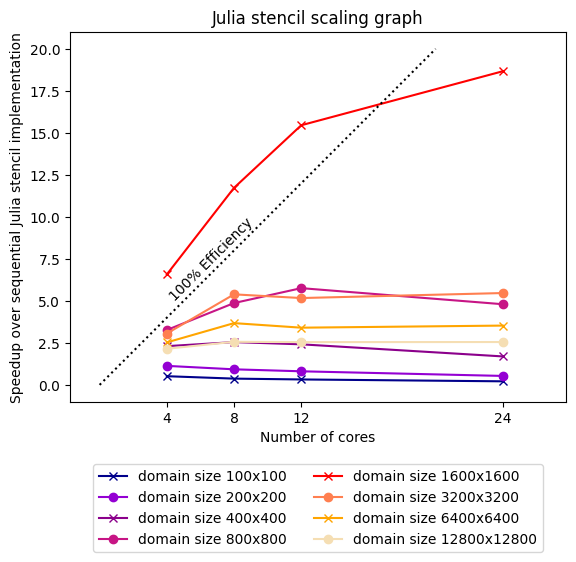

In [39]:
data24 = implementations_dict["julia_parallel_stencil_24_threads"]
data12 = implementations_dict["julia_parallel_stencil_12_threads"]
data8 = implementations_dict["julia_parallel_stencil_8_threads"]
data4 = implementations_dict["julia_parallel_stencil"]

baseline_data = implementations_dict["julia_sequential_stencil"]["mean"]

scaling_list = [data4, data8, data12, data24]
core_counts = [4, 8, 12, 24]
domains = [100, 200, 400, 800, 1600, 3200, 6400, 12800]
colors = ["darkblue", "darkviolet", "darkmagenta", "mediumvioletred", "red", "coral", "orange", "wheat"]
markers = ["x", "o", "x", "o", "x", "o", "x", "o", ]

ax = plt.gca()
ax.set_aspect('equal', adjustable='datalim')
for domain, i in zip(domains, range(len(domains))):
    data = []
    for cc in scaling_list:
        data.append(baseline_data[i] / cc["mean"][i])
    plt.plot(core_counts, data, label="domain size {}x{}".format(domain, domain), marker=markers[i], color=colors[i])
    
plt.xticks(core_counts)
plt.title("Julia stencil scaling graph")
plt.xlabel("Number of cores")
plt.ylabel("Speedup over sequential Julia stencil implementation")
plt.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=2)

plt.xlim([0, 26])


plt.plot([0, 20], [0, 20], color="black", linestyle="dotted")
    
plt.text(4, 5, "100% Efficiency", rotation=45)
    
plt.savefig("figures/cpu_scaling.pdf",bbox_inches='tight')

print(np.array(baseline_data)[4] / data4["mean"][4])

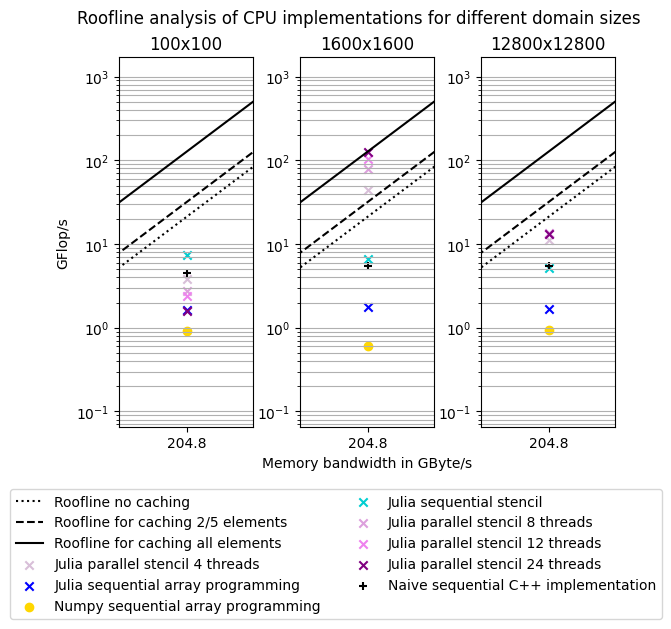

In [42]:
figs, ax = plt.subplots(1, 3)
markers = ["x", "x", "o", "o", "x", "x", "x", "x", "+"]

for di, d in zip([0, 4, 7], range(3)):
    domain = domains[di]
    flops = domain*domain*5*5000
    # no caching
    ax[d].plot([1, 10320], [5/48, 1075], color="black", linestyle="dotted", label="Roofline no caching")

    # caching two elements
    ax[d].plot([1, 6880], [5/32, 1075], color="black", linestyle="dashed", label="Roofline for caching 2/5 elements")

    # caching all elements except one
    ax[d].plot([1, 1720], [5/8, 1075], color="black", label="Roofline for caching all elements")

    ax[d].set_xlim([50, 800])
    ax[d].set_xscale("log")
    ax[d].set_yscale("log")
    ax[d].set_xticks([204.8])
    ax[d].set_xticklabels([204.8])
    ax[d].xaxis.set_minor_locator(plt.NullLocator())
    
    ax[d].set_title("{}x{}".format(domain, domain))
    
    ax[d].grid(which="both", axis="y")

    for implementation, i in zip(cpu_implementations + ["cpp_naive"], range(len(cpu_implementations) + 1)):
        if implementation != "python_lists":
            ax[d].scatter(204.8, flops / implementations_dict[implementation]["mean"][di] * 1e-9, label=implementations_dict[implementation]["label"], marker=markers[i], color=implementations_dict[implementation]["color"])
plt.legend(bbox_to_anchor=(1.4, -0.15), loc='upper right', ncol=2)
    
ax[1].set_xlabel("Memory bandwidth in GByte/s")
ax[0].set_label("Performance in GFLOP/s")

ax[0].set_ylabel("GFlop/s")

plt.suptitle("Roofline analysis of CPU implementations for different domain sizes")

figs.subplots_adjust(wspace=.35)

plt.savefig("figures/roofline.pdf",bbox_inches='tight')

In [ ]:
# plot throughput
def plot_implementations(implementations, data_dict, category="mean_speedup"):
    max_x = 0
    max_y = 0
    
    for implementation in implementations:
        data = data_dict[implementation][category]
        space = np.linspace(1, data.size, data.size)
        plt.plot(space, data, label=implementations_dict[implementation]["label"], color=implementations_dict[implementation]["color"])
        plt.fill_between(space, data - data_dict[implementation]["std_speedup"], data + data_dict[implementation]["std_speedup"], alpha=0.2, color=implementations_dict[implementation]["color"])
        max_x = np.max([max_x, space.size])
        max_y = np.max([max_y, np.max(data)])
        
    plt.xticks(np.linspace(1, 8, 8), grid_sizes)
    plt.xlabel("Domain size")
    plt.ylabel("Speedup compared to naive C++ implementation")
    plt.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=2)
    plt.plot([1, max_x], [1, 1], c="black", linestyle="dotted")
        
cpu_implementations = ["julia_parallel_stencil", "julia_sequential_array", "numpy_array", "python_lists", "julia_sequential_stencil", "julia_parallel_stencil_8_threads", "julia_parallel_stencil_12_threads", "julia_parallel_stencil_24_threads"]
gpu_implementations = ["pytorch_array", "cpp_cuda_stencil", "pytorch_conv", "julia_cuda_stencil", "julia_cuda_array"]
   
plt.title("Speedup of CPU implementations")     
plot_implementations(cpu_implementations, implementations_dict)
plt.yscale("log")
plt.savefig("figures/speedup_cpu_implementations.pdf",bbox_inches='tight')
plt.show()

plt.title("Speedup of GPU implementations")
plot_implementations(gpu_implementations, implementations_dict)
plt.savefig("figures/speedup_gpu_implementations.pdf",bbox_inches='tight')
plt.show()